# TP2 Deep QLearning

Dans ce TP, vous devez implémenter un agent apprenant à faire atterir un vaisseau sur la lune avec l'algorithme Deep Q-Network. Pour cela vous allez utiliser [PyTorch](https://pytorch.org/) et [Gymnasium](https://gymnasium.farama.org/). 

<img src='img/lunarlander.png'  width=500px>

# 1. Consignes

> Vous devez  <span style="color:red">compléter ce notebook et les différents fichiers python associés</span>.  <span style="color:red"> Vous commenterez votre code</span> dans le notebook et dans les fichiers python.
> 
> Vous devez aussi rendre un <span style="color:red">rapport en pdf</span> (à ajouter à votre dépôt) avec le détail des différentes expérimentations réalisées dans les parties 6 et 7, i.e. pour chaque apprentissage testé, préciser dans le rapport les différents hyper paramètres (architecture du réseau, coefficient(s) d'apprentissage, nombre d'épisodes, taille du buffer, décroissance d'epsilon, ... tout ce qui permet de reproduire l'expérience) et mettre la courbe d'apprentissage obtenu.

> Le code doit être fonctionnel avec l'environnement virtuel du TP. Si d'autres packages que ceux présents dans l'environnement virtuel créé au départ sont nécessaires, vous devez ajouter à votre dépôt un fichier `environnement.yaml` qui est un export de votre environnement virtuel. Ce fichier est obtenu avec la commande suivante:  ```conda env export > environnement.yaml```



# 2. Import des packages

In [1]:
%load_ext autoreload
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# 3. Gymnasium

En apprentissage par renforcement, il y a deux concepts fondamentaux : l’agent et l’environnement.
- L’agent est l’entité apprenante qui observe l’environnement et agit sur celui-ci selon les actions disponibles. Son objectif est de maximiser la récompense cumulée qu’il recoit de l’environnement avec lequel il interagit.
- L'agent interagit avec l'environnement à travers la boucle de perception/action ce qui nécessite de définir :
    - Un espace d’action.
    - Un espace d’état (ou observation).
    - Une fonction de récompense.
  
[Gymnasium](https://gymnasium.farama.org/) propose une interface open source unifiée entre un agent et un environnement.
- [Gymnasium](https://gymnasium.farama.org/) propose un ensemble d'environnements pour des tâches d'apprentissage par renforcement. La plupart des environnements ont leur code source disponible sur [GitHub](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs). De nouveaux environnements peuvent aussi être créés à condition qu'ils soient compatibles avec l'interface. 
- Grâce à l'interface unifiée, il est possible de définir indépendamment un agent de l’environnement avec lequel il interagit (et inversement). 
- Lorsque certains pré-traitements sont nécessaires sur les actions, observations, récompenses, ... il est possible d’encapsuler l’environnement dans un **wrapper**, celui-ci se chargera du pré-traitement. 



Dans ce TP, nous allons implémenter un agent qui interagira avec l'environnement [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Il existe plusieurs fonctions clé pour interagir avec un environnement.

>  <span style="color:green">Lisez la documentation de Gymnasium</span>: [utilisation basique](https://gymnasium.farama.org/content/basic_usage/), [API pour les environnements](https://gymnasium.farama.org/api/env/), ...




##  3.1 - Caractéristiques de l'environnement LunarLander-v2

> <span style="color:green">Compléter la cellule de code ci-dessous. A l'exécution devra s'afficher:
> 
> - **les dimensions pour les espaces d'états et d'actions** de l'environnement `LunarLander`.
> - les bornes min et max pour les dimensions de l'état
> - un échantillon pris au hasard dans chaque espace. 

In [2]:
env = gym.make("LunarLander-v2")
print("dimension de l'espace des observation : ", env.observation_space.shape[0])
print(" taille de l'espace des actions : ", env.action_space)
print("valeur minimale : ", env.observation_space.low)
print("valeur maximale : ", env.observation_space.high)
print("action au hasard : ", env.action_space.sample())
print("observation prise au hasard : ", env.observation_space.sample())



dimension de l'espace des observation :  8
 taille de l'espace des actions :  Discrete(4)
valeur minimale :  [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]
valeur maximale :  [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
action au hasard :  3
observation prise au hasard :  [-0.42516258 -0.77193356 -0.18500146  1.2427832   0.8066744   1.7123489
  0.19388252  0.59773993]


## 3.2 Interaction et affichage de l'environnement sur un épisode

> <span style="color:green">Exécuter une instance de l'environnement `LunarLander` pendant un épisode avec des **actions aléatoires**. Afficher l'environnement à chaque pas pour visualiser le comportement du vaisseau. A la fin de l'épisode, afficher la somme des récompenses obtenues sur l'épisode et la raison pour laquelle l'épisode s'est terminé. </span>



In [3]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()
terminated = False
truncated = False 
total_reward = 0
while not (terminated or truncated): 
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

env.close()
if truncated : 
    print("L'épisode c'est fini prématurément soit car l'agent a pris trop de temps soit qu'il est sortis de l'espace d'observation")
else :
    print("l'épisode c'est fini car l'agent a atteint le sol")

print("récompense total : ", total_reward)

/Users/timothebonhoure/miniconda3/envs/tpdeeprl2023/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


l'épisode c'est fini car l'agent a atteint le sol
récompense total :  -319.1272395927133


# 4. Agent glouton (sans apprentissage)

> <span style="color:green">Vous devez maintenant implémenter un **agent glouton** qui utilise un réseau de neurones pour représenter la Q fonction.</span>

- définir l'architecture du réseau de neurones en complétant `QNN.py`. Ce réseau va approximer la Q-fonction comme dans DQN (pour l'instant, les poids du réseau ne seront pas mis à jour, le réseau est uniquement utilisé en prédiction).

- définir un agent glouton en complétant `agentglouton.py`: il utilisera la prédiction du réseau de neurones pour choisir ses actions selon une stratégie d’exploration $\epsilon$-greedy.

- utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous utiliserez une décroissance de l'exploration, i.e. que $\epsilon$ va décroitre à chaque épisode, en démarrant à une valeur élevée (beaucoup d'exploration) et avec une borne minimum. Ainsi, au premier épisode, $\epsilon=\epsilon_{start}$, et à chaque épisode, $\epsilon=max(\epsilon_{end}, \epsilon_{decay}*\epsilon)$. Par exemple sur 1000 épisodes, les valeurs peuvent être $\epsilon_{start} = 1.0$, $\epsilon_{end} = 0.01$ et $\epsilon_{decay} = 0.995$.

- proposer un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser le fichier `utils.py`).


In [16]:
# import depuis un fichier python local 
%autoreload 2
from QNN import QNN 
%autoreload 2
from agentglouton import AgentGlouton
import utils

0
100
200
300
400
500
600
700
800
900


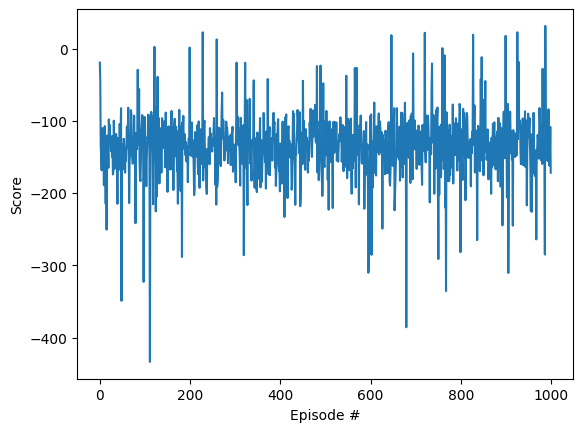

In [32]:
agent = AgentGlouton()

env = gym.make("LunarLander-v2")
eps_min = 0.01
eps_decay = 0.995
n_ep = 1_000
eps = 1
rewards = []

def runOneEpisode():
    observation, info = env.reset()
    terminated = False
    truncated = False 
    total_reward = 0
    while not (terminated or truncated): 
        action = agent.getAction(observation)  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
    return total_reward

for i in range(n_ep):
    if i % 100 == 0 :
        print(i)
    rewards.append(runOneEpisode())
    eps *= 0.995
    eps = max(eps, eps_min)

utils.plot_sumrwdperepi(rewards)
env.close()

# 5. Experience replay

L'algorithme DQN utilise l’experience replay:
- pendant la phase de **sample**, qui est une phase d'interaction avec l'environnement sans apprentissage, l'agent stocke en mémoire toutes les interactions (ou expériences) rencontrées. Une interaction est un tuple `(état,action,état_suivant,récompense,fin_episode)`.  Le buffer a une taille maximale (100 000 par exemple). Lorsqu’elle est dépassée, les nouvelles interactions remplacent les plus anciennes. 

- pendant la phase d'**apprentissage**, l’agent apprend à partir des interactions stockées dans son buffer. Il choisit aléatoirement un minibatch d’interactions dans son buffer (64 par exemple).

> <span style="color:green">Compléter la classe `ReplayBuffer` du fichier `replaybuffer.py` pour stockez les interactions et récupérer des mini-batchs. </span> 


In [33]:
%autoreload 2
from replaybuffer import ReplayBuffer

# 6. Deep QLearning avec Replay Buffer


Vous allez maintenant implémenter l'algorithme du **Deep QLearning avec ReplayBuffer** pour que votre agent apprenne en mettant à jour les poids de son réseau de neurone. 

- Après chaque interaction, le buffer sera remplit. 
- Une phase d'apprentissage sera réalisée toutes les `n` interactions (par ex. $n=4$), pendant laquelle un minibatch de données sera choisi dans le buffer pour réaliser la descente de gradient. Pour une interaction $(s,a,s',r)$, la valeur cible (erreur TD) sera calculée de la façon suivante:
    - $y = r(s,a) + \gamma max_b Q_\omega(s',b) $ si l'épisode continu
    - $y = r(s,a)  $ si l'épisode se termine

Remarque: vous n'utiliserez pas de réseau cible (*target network*) pour l'instant.


> <span style="color:green">Compléter la classe `AgentDQN` et utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous proposerez un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser `utils.py`), et une visualisation d'un épisode après apprentissage.</span> 
 
Pour l'optimizer, SGD et [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) sont particulièrement adaptés. 

Voici aussi des liens vers différentes fonctions de PyTorch qui pourraient vous être utiles:
- [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)
- [gather](https://pytorch.org/docs/stable/generated/torch.gather.html)
 
 

In [34]:
from agentdqn import AgentDQN

SyntaxError: non-default argument follows default argument (agentdqn.py, line 17)

: 

In [14]:
#TODO

    

# 7. Deep QLearning avec réseau cible

Il se peut que votre agent précédent apprenne des comportements intéressants mais qu’ils soient très instables. On va maintenant ajouter un réseau cible pour l'améliorer.

> <span style="color:green"> Compléter la classe `AgentDQNTarget` pour implémenter un agent apprenant avec DQN (deep QLearning et *target network*) pour stabiliser l’apprentissage. Utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous proposerez un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser `utils.py`), et une visualisation d'un épisode après apprentissage.</span> 
 
 
Pour la mise à jour du réseau cible, vous pouvez:
- toutes les N étapes d'apprentissage (10000 par exemple), recopier entièrement le réseau de neurone original dans le duplicat
- mettre à jour petit à petit le duplicat à chaque étape d’apprentissage : $$\omega' = (1-\tau)\omega' +\alpha \omega$$ où $\omega'$ sont les poids du duplicat, $\omega$ les poids du réseau original, et $\tau$ le pas de mise à jour. Souvent $\tau = 0.001$.


Pour copier des poids d'un réseau de neurone vers un autre, la méthode `copy_` peut être appelée sur les paramètres:

`for param_duplicat, param_source in zip(model_duplicat.parameters(), model_source.parameters()):`
           
`param_duplicat.data.copy_(param_source.data)`






In [2]:
from agentdqntarget import agentDQNTarget

ImportError: cannot import name 'agentDQNTarget' from 'agentdqntarget' (/Users/timothebonhoure/Documents/GitHub/2023-m2ia-intagents-tp2-timothe-bonhoure/agentdqntarget.py)

In [ ]:
# TODO

In [15]:
#TODO corrige
import utils
from QNNC import QNNC
from replaybufferC import ReplayBufferC
from agentdqnC import AgentDQNC
from agentdqntargetC import AgentDQNTargetC
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

QNNC(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


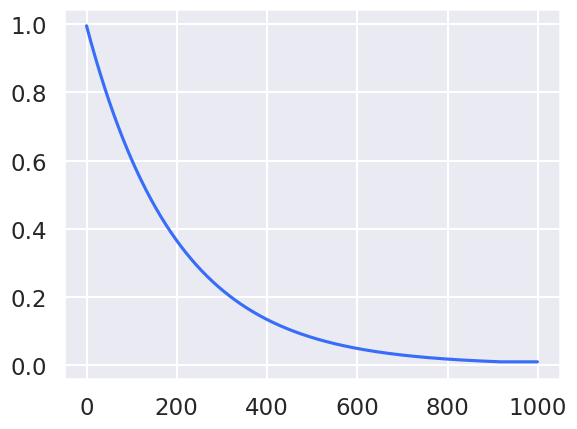

Episode: 100/1000 epsilon: 0.6057704364907278 Average Reward:  -206.47662353515625
Episode: 200/1000 epsilon: 0.3669578217261671 Average Reward:  -179.70480346679688


In [ ]:
#Correction
env = gym.make("LunarLander-v2")#a remettre sinon erreur ...
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode reward/length, 50= taille du buffer

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

dqlagent = AgentDQNTargetC(state_size,action_size,gamma=0.99)
print(dqlagent.qnetwork_local)

nb_episodes = 1000
dqlalgo(dqlagent,wrapped_env,nb_episodes,eps_start,eps_end,eps_decay)

### sauvegarde reseau

In [15]:
#sauvegarde du réseau 
savedfile = 'checkpoint_DQNtarget_3232.pth'
torch.save(dqlagent.qnetwork_local.state_dict(), savedfile)

In [16]:
#TODO: verif que fonctionne 
state_dict = torch.load(savedfile)
print(state_dict.keys())
dqlagentb = DQLAgentC(state_size,action_size,gamma=0.99)
dqlagentb.qnetwork.load_state_dict(state_dict)
print(dqlagentb.qnetwork)

#dqlalgo(dqlagent,50,eps_start,eps_end,eps_decay,True)

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
QNNC(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


### voir politique apprise

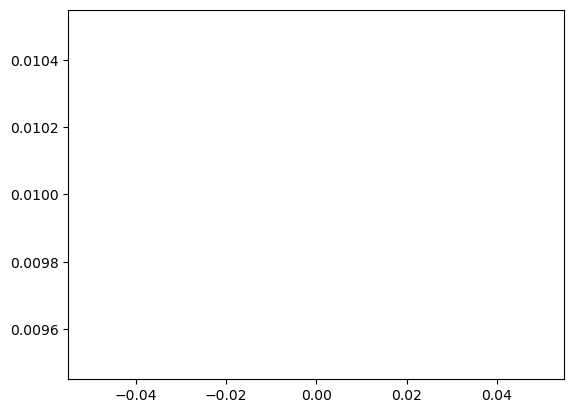

AttributeError: 'LunarLander' object has no attribute 'return_queue'

In [22]:
env = gym.make("LunarLander-v2", render_mode="human")#a remettre sinon erreur ...
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
savedfile = 'checkpoint_DQNtarget_3232.pth'
state_dict = torch.load(savedfile)
dqlagentb = DQLAgentTargetC(state_size,action_size,gamma=0.99)
dqlagentb.qnetwork_local.load_state_dict(state_dict)
eps_start = 0.01
eps_end = 0.01
eps_decay = 0.995
nb_episodes = 1
dqlalgo(dqlagentb,env,nb_episodes,eps_start,eps_end,eps_decay)